# Имплементация модели и её обучение

In [4]:
import glob
import os
import sys
import math
import time
import random
import pickle
import joblib
from tqdm import tqdm
import torch

from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import torch.nn as nn
from torch.optim.lr_scheduler import LambdaLR
from torch.nn.modules.normalization import LayerNorm

In [2]:
midi_folder = '/home/storage/3020/db/K_cluster2_backup/TD/data'
train_percentage = 0.8
midi_list = glob.glob(midi_folder + '/*')

random.shuffle(midi_list)
train_list, val_list, test_list = [], [], []
tr_files, val_files, test_files = [], [], []
for file in tqdm(midi_list[:int(len(midi_list) * train_percentage)]):
    seqs = joblib.load(file)
    name = file.split('/')[-1]
    tr_files.append(file)
    for idx, seq in enumerate(seqs):
        if len(seq) == 0:
            continue
        train_list.append(seq)
        
for file in tqdm(midi_list[int(len(midi_list) * train_percentage):]):
    seqs = joblib.load(file)
    name = file.split('/')[-1]
    if random.random() > 0.5:
        val_files.append(file)
        for idx, seq in enumerate(seqs):
            if len(seq) == 0:
                continue
            val_list.append(seq)
    else:
        test_files.append(file)
        for idx, seq in enumerate(seqs):
            if len(seq) == 0:
                continue
            test_list.append(seq)

100%|██████████| 256/256 [03:36<00:00,  1.18it/s]


In [5]:
split_dict = {'train' : tr_files, 'val' : val_files, 'test' : test_files}
with open(midi_folder + '/data_split.pkl', 'wb') as f:
    pickle.dump(split_dict, f)

In [6]:
print(f'Train length: {len(train_list)}')
print(f'Val length: {len(val_list)}')
print(f'Test length: {len(test_list)}')

Train length: 293775
Val length: 37065
Test length: 34815


# Constants

In [7]:
SEQUENCE_START = 0
RANGE_NOTE_ON = 128
RANGE_NOTE_OFF = 128
RANGE_VEL = 32
RANGE_TIME_SHIFT = 100

START_IDX = {
    'note_on': 0,
    'note_off': RANGE_NOTE_ON,
    'time_shift': RANGE_NOTE_ON + RANGE_NOTE_OFF,
    'velocity': RANGE_NOTE_ON + RANGE_NOTE_OFF + RANGE_TIME_SHIFT
}


SEPERATOR               = "========================="

# Taken from the paper
ADAM_BETA_1             = 0.9
ADAM_BETA_2             = 0.98
ADAM_EPSILON            = 10e-9

LR_DEFAULT_START        = 1.0
SCHEDULER_WARMUP_STEPS  = 4000
# LABEL_SMOOTHING_E       = 0.1

# DROPOUT_P               = 0.1

TOKEN_END               = RANGE_NOTE_ON + RANGE_NOTE_OFF + RANGE_VEL + RANGE_TIME_SHIFT
TOKEN_PAD               = TOKEN_END + 1

VOCAB_SIZE              = TOKEN_PAD + 1

TORCH_FLOAT             = torch.float32
TORCH_INT               = torch.int32

TORCH_LABEL_TYPE        = torch.long

PREPEND_ZEROS_WIDTH     = 4

TORCH_CPU_DEVICE = torch.device("cpu")
USE_CUDA = 1
TORCH_CUDA_DEVICE = torch.device("cuda:9")

In [8]:
def cpu_device():
    """
    ----------
    Author: Damon Gwinn
    ----------
    Grabs the cpu device
    ----------
    """

    return TORCH_CPU_DEVICE

def get_device():
    """
    ----------
    Author: Damon Gwinn
    ----------
    Grabs the default device. Default device is CUDA if available and use_cuda is not False, CPU otherwise.
    ----------
    """

    if((not USE_CUDA) or (TORCH_CUDA_DEVICE is None)):
        return TORCH_CPU_DEVICE
    else:
        return TORCH_CUDA_DEVICE

# Dataset

In [9]:
class EPianoDataset(Dataset):
    """
    ----------
    Author: Damon Gwinn
    ----------
    Pytorch Dataset for the Maestro e-piano dataset (https://magenta.tensorflow.org/datasets/maestro).
    Recommended to use with Dataloader (https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)
    Uses all files found in the given root directory of pre-processed (preprocess_midi.py)
    Maestro midi files.
    ----------
    """

    def __init__(self, midi_list, max_seq=2048, random_seq=True):
        self.max_seq    = max_seq
        self.random_seq = random_seq
        self.data_files = midi_list

    def __len__(self):
        """
        ----------
        Author: Damon Gwinn
        ----------
        How many data files exist in the given directory
        ----------
        """

        return len(self.data_files)

    def __getitem__(self, idx):
        """
        ----------
        Author: Damon Gwinn
        ----------
        Gets the indexed midi batch. Gets random sequence or from start depending on random_seq.
        Returns the input and the target.
        ----------
        """

        raw_mid = torch.tensor(self.data_files[idx], dtype=TORCH_LABEL_TYPE, device=cpu_device())
        x, tgt = process_midi(raw_mid, self.max_seq, self.random_seq)

        return x, tgt
    
def process_midi(raw_mid, max_seq, random_seq):
    """
    ----------
    Author: Damon Gwinn
    ----------
    Takes in pre-processed raw midi and returns the input and target. Can use a random sequence or
    go from the start based on random_seq.
    ----------
    """

    x   = torch.full((max_seq, ), TOKEN_PAD, dtype=TORCH_LABEL_TYPE, device=cpu_device())
    tgt = torch.full((max_seq, ), TOKEN_PAD, dtype=TORCH_LABEL_TYPE, device=cpu_device())

    raw_len     = len(raw_mid)
    full_seq    = max_seq + 1 # Performing seq2seq

    if(raw_len == 0):
        return x, tgt

    if(raw_len < full_seq):
        if tgt.shape[0] == raw_len:
            #print(f'Tgt shape: {tgt.shape} Raw len: {raw_len} Skipping')
            x[:raw_len]         = raw_mid
            tgt[:raw_len-1]     = raw_mid[1:]
            tgt[raw_len-1]        = TOKEN_END
        else:
            x[:raw_len]         = raw_mid
            tgt[:raw_len-1]     = raw_mid[1:]
            tgt[raw_len]        = TOKEN_END
    else:
        # Randomly selecting a range
        if(random_seq):
            end_range = raw_len - full_seq
            start = random.randint(SEQUENCE_START, end_range)

        # Always taking from the start to as far as we can
        else:
            start = SEQUENCE_START

        end = start + full_seq

        data = raw_mid[start:end]

        x = data[:max_seq]
        tgt = data[1:full_seq]

    return x, tgt

Гиперпараметры обучения и параметры модели

In [10]:
weight_modulus = 1
print_modulus = 1
n_workers = 1

lr = None
ce_smoothing = None
batch_size = 2
random_seq = True
epochs = 100

rpr = False #'store_true'
max_seq = 2048
n_layers = 6
num_heads = 8
d_model = 512
dim_feedforward = 1024
dropout = 0.1

Инициализируем датасеты собранными списками последовательностей

In [11]:
train_dataset = EPianoDataset(train_list, max_seq, random_seq)
val_dataset = EPianoDataset(val_list, max_seq, random_seq)
test_dataset = EPianoDataset(test_list, max_seq, random_seq)

In [12]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=n_workers, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=n_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=n_workers)

Проверим выходные шейпы

In [13]:
print('Train loader')
for x, tgt in train_loader:
    print(f'X shape: {x.shape}')
    print(f'Target shape: {tgt.shape}')
    break

print('Validation loader')
for x, tgt in val_loader:
    print(f'X shape: {x.shape}')
    print(f'Target shape: {tgt.shape}')
    break

print('Test loader')
for x, tgt in test_loader:
    print(f'X shape: {x.shape}')
    print(f'Target shape: {tgt.shape}')
    break

Train loader
X shape: torch.Size([2, 2048])
Target shape: torch.Size([2, 2048])
Validation loader
X shape: torch.Size([2, 2048])
Target shape: torch.Size([2, 2048])
Test loader
X shape: torch.Size([2, 2048])
Target shape: torch.Size([2, 2048])


# Инициализация модели, оптимизатора и schedulera

In [14]:
class MusicTransformer(nn.Module):
    """
    ----------
    Author: Damon Gwinn
    ----------
    Music Transformer reproduction from https://arxiv.org/abs/1809.04281. Arguments allow for
    tweaking the transformer architecture (https://arxiv.org/abs/1706.03762) and the rpr argument
    toggles Relative Position Representations (RPR - https://arxiv.org/abs/1803.02155).
    Supports training and generation using Pytorch's nn.Transformer class with dummy decoder to
    make a decoder-only transformer architecture
    For RPR support, there is modified Pytorch 1.2.0 code in rpr.py. Modified source will be
    kept up to date with Pytorch revisions only as necessary.
    ----------
    """

    def __init__(self, n_layers=6, num_heads=8, d_model=512, dim_feedforward=1024,
                 dropout=0.1, max_sequence=2048, rpr=False):
        super(MusicTransformer, self).__init__()

        self.dummy      = DummyDecoder()

        self.nlayers    = n_layers
        self.nhead      = num_heads
        self.d_model    = d_model
        self.d_ff       = dim_feedforward
        self.dropout    = dropout
        self.max_seq    = max_sequence
        self.rpr        = rpr

        # Input embedding
        self.embedding = nn.Embedding(VOCAB_SIZE, self.d_model)

        # Positional encoding
        self.positional_encoding = PositionalEncoding(self.d_model, self.dropout, self.max_seq)

        # Base transformer
        if(not self.rpr):
            # To make a decoder-only transformer we need to use masked encoder layers
            # Dummy decoder to essentially just return the encoder output
            self.transformer = nn.Transformer(
                d_model=self.d_model, nhead=self.nhead, num_encoder_layers=self.nlayers,
                num_decoder_layers=0, dropout=self.dropout, # activation=self.ff_activ,
                dim_feedforward=self.d_ff, custom_decoder=self.dummy
            )
        # RPR Transformer
        else:
            encoder_norm = LayerNorm(self.d_model)
            encoder_layer = TransformerEncoderLayerRPR(self.d_model, self.nhead, self.d_ff, self.dropout, er_len=self.max_seq)
            encoder = TransformerEncoderRPR(encoder_layer, self.nlayers, encoder_norm)
            self.transformer = nn.Transformer(
                d_model=self.d_model, nhead=self.nhead, num_encoder_layers=self.nlayers,
                num_decoder_layers=0, dropout=self.dropout,
                dim_feedforward=self.d_ff, custom_decoder=self.dummy, custom_encoder=encoder
            )

        # Final output is a softmaxed linear layer
        self.Wout       = nn.Linear(self.d_model, VOCAB_SIZE)
        self.softmax    = nn.Softmax(dim=-1)

    # forward
    def forward(self, x, mask=True):
        """
        ----------
        Author: Damon Gwinn
        ----------
        Takes an input sequence and outputs predictions using a sequence to sequence method.
        A prediction at one index is the "next" prediction given all information seen previously.
        ----------
        """

        if(mask is True):
            mask = self.transformer.generate_square_subsequent_mask(x.shape[1]).to(get_device())
        else:
            mask = None

        x = self.embedding(x)

        # Input shape is (max_seq, batch_size, d_model)
        x = x.permute(1,0,2)

        x = self.positional_encoding(x)

        # Since there are no true decoder layers, the tgt is unused
        # Pytorch wants src and tgt to have some equal dims however
        x_out = self.transformer(src=x, tgt=x, src_mask=mask)

        # Back to (batch_size, max_seq, d_model)
        x_out = x_out.permute(1,0,2)

        y = self.Wout(x_out)

        del mask

        # They are trained to predict the next note in sequence (we don't need the last one)
        return y

    # generate
    def generate(self, primer=None, target_seq_length=1024, beam=0, beam_chance=1.0):
        """
        ----------
        Author: Damon Gwinn
        ----------
        Generates midi given a primer sample. Music can be generated using a probability distribution over
        the softmax probabilities (recommended) or by using a beam search.
        ----------
        """

        assert (not self.training), "Cannot generate while in training mode"

        print("Generating sequence of max length:", target_seq_length)

        gen_seq = torch.full((1,target_seq_length), TOKEN_PAD, dtype=TORCH_LABEL_TYPE, device=get_device())

        num_primer = len(primer)
        gen_seq[..., :num_primer] = primer.type(TORCH_LABEL_TYPE).to(get_device())

        cur_i = num_primer
        while(cur_i < target_seq_length):

            y = self.softmax(self.forward(gen_seq[..., :cur_i]))[..., :TOKEN_END]
            token_probs = y[:, cur_i-1, :]

            if(beam == 0):
                beam_ran = 2.0
            else:
                beam_ran = random.uniform(0,1)

            if(beam_ran <= beam_chance):
                token_probs = token_probs.flatten()
                top_res, top_i = torch.topk(token_probs, beam)

                beam_rows = top_i // VOCAB_SIZE
                beam_cols = top_i % VOCAB_SIZE

                gen_seq = gen_seq[beam_rows, :]
                gen_seq[..., cur_i] = beam_cols

            else:
                distrib = torch.distributions.categorical.Categorical(probs=token_probs)
                next_token = distrib.sample()
                gen_seq[:, cur_i] = next_token


                # Let the transformer decide to end if it wants to
                if(next_token == TOKEN_END):
                    print("Model called end of sequence at:", cur_i, "/", target_seq_length)
                    break

            cur_i += 1
            if(cur_i % 50 == 0):
                print(cur_i, "/", target_seq_length)

        return gen_seq[:, :cur_i]

class DummyDecoder(nn.Module):
    """
    ----------
    Author: Damon Gwinn
    ----------
    A dummy decoder that returns its input. Used to make the Pytorch transformer into a decoder-only
    architecture (stacked encoders with dummy decoder fits the bill)
    ----------
    """

    def __init__(self):
        super(DummyDecoder, self).__init__()

    def forward(self, tgt, memory, tgt_mask, memory_mask,tgt_key_padding_mask,memory_key_padding_mask):
        """
        ----------
        Author: Damon Gwinn
        ----------
        Returns the input (memory)
        ----------
        """

        return memory
    
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)
    
class LrStepTracker:
    """
    ----------
    Author: Ryan Marshall
    Modified: Damon Gwinn
    ----------
    Class for custom learn rate scheduler (to be used by torch.optim.lr_scheduler.LambdaLR).
    Learn rate for each step (batch) given the warmup steps is:
        lr = [ 1/sqrt(d_model) ] * min[ 1/sqrt(step) , step * (warmup_steps)^-1.5 ]
    This is from Attention is All you Need (https://arxiv.org/abs/1706.03762)
    ----------
    """

    def __init__(self, model_dim=512, warmup_steps=4000, init_steps=0):
        # Store Values
        self.warmup_steps = warmup_steps
        self.model_dim = model_dim
        self.init_steps = init_steps

        # Begin Calculations
        self.invsqrt_dim = (1 / math.sqrt(model_dim))
        self.invsqrt_warmup = (1 / (warmup_steps * math.sqrt(warmup_steps)))

    # step
    def step(self, step):
        """
        ----------
        Author: Ryan Marshall
        Modified: Damon Gwinn
        ----------
        Method to pass to LambdaLR. Increments the step and computes the new learn rate.
        ----------
        """

        step += self.init_steps
        if(step <= self.warmup_steps):
            return self.invsqrt_dim * self.invsqrt_warmup * step
        else:
            invsqrt_step = (1 / math.sqrt(step))
            return self.invsqrt_dim * invsqrt_step

# get_lr
def get_lr(optimizer):
    """
    ----------
    Author: Damon Gwinn
    ----------
    Hack to get the current learn rate of the model
    ----------
    """

    for param_group in optimizer.param_groups:
        return param_group['lr']

In [15]:
def train(cur_epoch, model, dataloader, loss, opt, lr_scheduler=None, num_iters=-1):
    best_eval_acc        = 0.0
    best_eval_acc_epoch  = -1
    best_eval_loss       = float("inf")
    best_eval_loss_epoch = -1
    loss_hist = []
    
    out = -1
    model.train()
    with tqdm(total=len(dataloader)) as bar_train:
        for batch_num, batch in enumerate(dataloader):
            time_before = time.time()

            opt.zero_grad()

            x   = batch[0].to(get_device())
            tgt = batch[1].to(get_device())

            y = model(x)

            y   = y.reshape(y.shape[0] * y.shape[1], -1)
            tgt = tgt.flatten()

            out = loss.forward(y, tgt)

            out.backward()
            opt.step()

            if(lr_scheduler is not None):
                lr_scheduler.step()

            time_after = time.time()
            time_took = time_after - time_before
            bar_train.set_description(f'Epoch: {cur_epoch} Loss: {float(out):.4}')
            bar_train.update(1)
            loss_hist.append(out.item())
            if batch_num == num_iters:
                break

    return loss_hist

def compute_epiano_accuracy(out, tgt):
    softmax = nn.Softmax(dim=-1)
    out = torch.argmax(softmax(out), dim=-1)

    out = out.flatten()
    tgt = tgt.flatten()

    mask = (tgt != TOKEN_PAD)

    out = out[mask]
    tgt = tgt[mask]

    if(len(tgt) == 0):
        return 1.0

    num_right = (out == tgt)
    num_right = torch.sum(num_right).type(TORCH_FLOAT)

    acc = num_right / len(tgt)

    return acc

def eval_model(model, dataloader, loss, num_iters=-1):
    model.eval()

    avg_acc     = -1
    avg_loss    = -1
    with torch.set_grad_enabled(False):
        n_test      = len(dataloader)
        sum_loss   = 0.0
        sum_acc    = 0.0
        with tqdm(total=len(dataloader)) as bar_eval:
            for batch in dataloader:
                x   = batch[0].to(get_device())
                tgt = batch[1].to(get_device())

                y = model(x)

                sum_acc += float(compute_epiano_accuracy(y, tgt))

                y   = y.reshape(y.shape[0] * y.shape[1], -1)
                tgt = tgt.flatten()

                out = loss.forward(y, tgt)

                sum_loss += float(out)
                bar_eval.set_description(f'Loss val: {float(out):.4}  Acc: {float(sum_acc / (bar_eval.n + 1)):.4}')
                bar_eval.update(1)
                if bar_eval.n == num_iters:
                    break

        avg_loss    = sum_loss / n_test
        avg_acc     = sum_acc / n_test

    return avg_loss, avg_acc

In [30]:
model = MusicTransformer(n_layers=n_layers, num_heads=num_heads,
            d_model=d_model, dim_feedforward=dim_feedforward, dropout=dropout,
            max_sequence=max_seq, rpr=rpr).to(get_device())
model

MusicTransformer(
  (dummy): DummyDecoder()
  (embedding): Embedding(390, 512)
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=1024, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1024, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (

In [31]:
init_step = 0
lr = LR_DEFAULT_START
lr_stepper = LrStepTracker(d_model, SCHEDULER_WARMUP_STEPS, init_step)
eval_loss_func = nn.CrossEntropyLoss(ignore_index=TOKEN_PAD)
train_loss_func = eval_loss_func

opt = Adam(model.parameters(), lr=lr, betas=(ADAM_BETA_1, ADAM_BETA_2), eps=ADAM_EPSILON)
lr_scheduler = LambdaLR(opt, lr_stepper.step)

n_workers = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=n_workers, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=n_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=n_workers)

In [32]:
best_eval_acc        = 0.0
best_eval_acc_epoch  = -1
best_eval_loss       = float("inf")
best_eval_loss_epoch = -1
best_acc_file = '/home/storage/3020/db/K_cluster2_backup/TD/gpt1_best_acc_bsize2.pth'
best_loss_file = '/home/storage/3020/db/K_cluster2_backup/TD/gpt1_best_loss_bsize2.pth'
loss_train, loss_val, acc_val = [], [], []

for epoch in range(0, epochs):
    new_best = False
    
    loss = train(epoch+1, model, train_loader, train_loss_func, opt, lr_scheduler)
    loss_train.append(loss)
    
    eval_loss, eval_acc = eval_model(model, val_loader, eval_loss_func)
    loss_val.append(eval_loss)
    acc_val.append(eval_acc)
    
    if(eval_acc > best_eval_acc):
        best_eval_acc = eval_acc
        best_eval_acc_epoch  = epoch+1
        torch.save(model.state_dict(), best_acc_file)
        new_best = True

    if(eval_loss < best_eval_loss):
        best_eval_loss       = eval_loss
        best_eval_loss_epoch = epoch+1
        torch.save(model.state_dict(), best_loss_file)
        new_best = True
    
    if(new_best):
        print("Best eval acc epoch:", best_eval_acc_epoch)
        print("Best eval acc:", best_eval_acc)
        print("")
        print("Best eval loss epoch:", best_eval_loss_epoch)
        print("Best eval loss:", best_eval_loss)

Epoch: 1 Loss: 3.138:   8%|▊         | 11625/146888 [41:14<8:10:26,  4.60it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch: 1 Loss: 2.648:  10%|▉         | 14208/146888 [50:22<7:47:54,  4.73it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch: 1 Loss: 2.47:  11%|█▏        | 16706/146888 [59:12<7:38:40,  4.73it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoi

Epoch: 1 Loss: 2.134:  89%|████████▊ | 130361/146888 [7:39:27<58:16,  4.73it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch: 1 Loss: 2.561:  90%|█████████ | 132455/146888 [7:46:49<50:55,  4.72it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch: 1 Loss: 2.275:  92%|█████████▏| 134710/146888 [7:54:44<43:56,  4.62it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to

Best eval acc epoch: 1
Best eval acc: 0.3695071290006384

Best eval loss epoch: 1
Best eval loss: 2.1310212398021777


Epoch: 2 Loss: 2.102:   1%|          | 887/146888 [03:04<8:13:30,  4.93it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch: 2 Loss: 1.888:   2%|▏         | 3062/146888 [10:25<8:16:59,  4.82it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch: 2 Loss: 2.381:   4%|▎         | 5253/146888 [17:51<7:54:35,  4.97it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid cr

Epoch: 2 Loss: 2.083:  31%|███       | 45504/146888 [2:35:00<5:40:15,  4.97it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch: 2 Loss: 2.094:  32%|███▏      | 47650/146888 [2:42:19<5:45:25,  4.79it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch: 2 Loss: 2.072:  34%|███▍      | 49781/146888 [2:49:33<5:22:28,  5.02it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order t

Epoch: 2 Loss: 2.315:  61%|██████    | 89671/146888 [5:05:32<3:20:33,  4.75it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch: 2 Loss: 1.985:  63%|██████▎   | 91902/146888 [5:13:10<3:11:05,  4.80it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch: 2 Loss: 1.996:  64%|██████▍   | 94093/146888 [5:20:40<3:03:16,  4.80it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order t

Epoch: 2 Loss: 1.979:  90%|█████████ | 132600/146888 [7:32:56<52:58,  4.49it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch: 2 Loss: 2.171:  92%|█████████▏| 134822/146888 [7:41:20<44:57,  4.47it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch: 2 Loss: 1.975:  93%|█████████▎| 137017/146888 [7:49:14<34:29,  4.77it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to

Epoch: 3 Loss: 2.302:   7%|▋         | 10140/146888 [36:52<7:43:53,  4.91it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch: 3 Loss: 1.635:   8%|▊         | 12293/146888 [44:16<7:30:48,  4.98it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch: 3 Loss: 1.863:  10%|▉         | 14370/146888 [51:25<7:33:09,  4.87it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoi

Epoch: 3 Loss: 1.926:  38%|███▊      | 55794/146888 [3:14:13<5:11:11,  4.88it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch: 3 Loss: 1.753:  39%|███▉      | 57872/146888 [3:21:24<5:09:50,  4.79it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch: 3 Loss: 2.383:  41%|████      | 60066/146888 [3:28:58<4:56:16,  4.88it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order t

Epoch: 3 Loss: 1.964:  69%|██████▉   | 101291/146888 [5:51:25<2:38:38,  4.79it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch: 3 Loss: 2.131:  70%|███████   | 103447/146888 [5:58:55<2:31:32,  4.78it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch: 3 Loss: 1.634:  72%|███████▏  | 105618/146888 [6:06:25<2:22:11,  4.84it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in orde

Epoch: 3 Loss: 2.003:  99%|█████████▉| 145362/146888 [8:23:25<05:10,  4.91it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss val: 2.103  Acc: 0.3912:   3%|▎         | 550/18533 [01:01<32:52,  9.12it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss val: 2.009  Acc: 0.3919:  15%|█▍        | 2772/18533 [04:57<29:11,  9.00it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in orde

Best eval acc epoch: 3
Best eval acc: 0.38540276075772484

Best eval loss epoch: 3
Best eval loss: 2.046204640476431


Epoch: 4 Loss: 1.956:   1%|          | 1483/146888 [05:08<8:50:00,  4.57it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch: 4 Loss: 1.878:   3%|▎         | 3691/146888 [12:43<8:05:15,  4.92it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch: 4 Loss: 2.13:   4%|▍         | 5860/146888 [20:11<8:08:28,  4.81it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid c

Epoch: 4 Loss: 2.048:  32%|███▏      | 47511/146888 [2:42:07<5:32:13,  4.99it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch: 4 Loss: 2.015:  34%|███▎      | 49476/146888 [2:48:47<5:25:28,  4.99it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch: 4 Loss: 2.362:  35%|███▌      | 51440/146888 [2:55:29<5:31:00,  4.81it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order t

Epoch: 4 Loss: 2.086:  62%|██████▏   | 91389/146888 [5:12:16<3:13:29,  4.78it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch: 4 Loss: 2.135:  64%|██████▎   | 93548/146888 [5:19:38<3:04:04,  4.83it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch: 4 Loss: 2.189:  65%|██████▌   | 95582/146888 [5:26:38<2:54:58,  4.89it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order t

Epoch: 4 Loss: 2.127:  91%|█████████ | 133452/146888 [7:36:21<45:39,  4.90it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch: 4 Loss: 1.992:  92%|█████████▏| 135415/146888 [7:43:08<40:15,  4.75it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch: 4 Loss: 2.116:  94%|█████████▎| 137528/146888 [7:50:22<32:22,  4.82it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to a

Best eval acc epoch: 4
Best eval acc: 0.38853972697903794

Best eval loss epoch: 4
Best eval loss: 2.031354831284303


Epoch: 5 Loss: 2.023:   0%|          | 350/146888 [01:15<8:05:02,  5.04it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch: 5 Loss: 1.989:   2%|▏         | 2245/146888 [07:42<8:31:54,  4.71it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch: 5 Loss: 1.886:   3%|▎         | 4296/146888 [14:43<7:59:33,  4.96it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid cr

Epoch: 5 Loss: 1.967:  31%|███       | 44934/146888 [2:33:41<5:48:47,  4.87it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch: 5 Loss: 2.057:  32%|███▏      | 47044/146888 [2:40:56<5:41:04,  4.88it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch: 5 Loss: 1.748:  33%|███▎      | 49082/146888 [2:47:59<5:42:50,  4.75it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order t

Epoch: 5 Loss: 1.841:  61%|██████    | 88943/146888 [5:05:14<3:15:39,  4.94it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch: 5 Loss: 2.152:  62%|██████▏   | 90942/146888 [5:12:07<3:08:17,  4.95it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch: 5 Loss: 1.901:  63%|██████▎   | 93093/146888 [5:19:31<3:02:29,  4.91it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order t

Epoch: 5 Loss: 2.377:  89%|████████▉ | 130446/146888 [7:27:57<55:59,  4.89it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch: 5 Loss: 1.75:  90%|█████████ | 132462/146888 [7:34:53<48:35,  4.95it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch: 5 Loss: 2.191:  92%|█████████▏| 134479/146888 [7:41:50<41:45,  4.95it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to

Best eval acc epoch: 5
Best eval acc: 0.39086881633318293

Best eval loss epoch: 5
Best eval loss: 2.020655914698083


Epoch: 6 Loss: 1.766:   1%|          | 927/146888 [03:13<8:22:32,  4.84it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch: 6 Loss: 1.906:   2%|▏         | 2931/146888 [10:04<8:04:35,  4.95it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch: 6 Loss: 1.967:   4%|▎         | 5155/146888 [18:24<9:30:49,  4.14it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid c

Epoch: 6 Loss: 1.864:  31%|███▏      | 45909/146888 [2:54:37<6:39:13,  4.22it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch: 6 Loss: 2.015:  33%|███▎      | 48260/146888 [3:03:37<6:08:31,  4.46it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch: 6 Loss: 1.997:  34%|███▍      | 50456/146888 [3:12:06<6:26:16,  4.16it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order t

Best eval acc epoch: 6
Best eval acc: 0.3926670438486045

Best eval loss epoch: 6
Best eval loss: 2.0118985157432836


Epoch: 7 Loss: 2.0:   2%|▏         | 2359/146888 [08:11<8:13:26,  4.88it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch: 7 Loss: 2.124:   3%|▎         | 4968/146888 [17:13<8:01:18,  4.91it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch: 7 Loss: 2.04:   5%|▌         | 7556/146888 [26:05<7:50:30,  4.94it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid c

Epoch: 7 Loss: 2.096:  63%|██████▎   | 92555/146888 [5:20:03<3:07:53,  4.82it/s]


KeyboardInterrupt: 

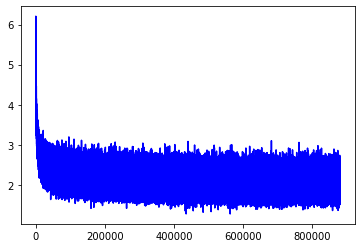

In [33]:
import matplotlib.pyplot as plt
tr_loss_list = [item for sublist in loss_train for item in sublist]
plt.plot([i for i in range(len(tr_loss_list))] ,tr_loss_list, 'b')

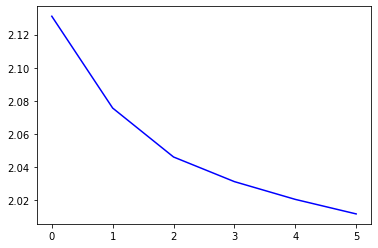

In [34]:
plt.plot([i for i in range(len(loss_val))], loss_val, 'b')

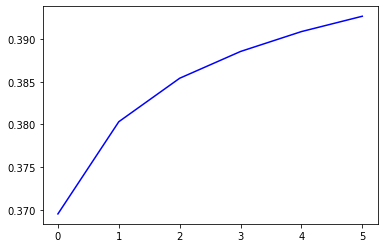

In [35]:
plt.plot([i for i in range(len(acc_val))], acc_val, 'b')

In [37]:
res_dict = {'tr_loss': tr_loss_list,
            'loss_val': loss_val,
            'acc_val': acc_val,
            'n_layers': n_layers,
            'num_heads': num_heads,
            'd_model': d_model,
            'dim_feedforward': dim_feedforward,
            'dropout': dropout,
            'max_seq': max_seq,
            'rpr': rpr}
with open('/home/storage/3020/db/K_cluster2_backup/TD/gpt1_best_acc_bsize2_scores_params.pkl', 'wb') as f:
    pickle.dump(res_dict, f)